# SimMod 2. Audio + Video features
## 1. Author Documentation

- Alexander Haberl (11806899)
- Alina Godun (01569197)

### Timesheets
#### Alexander Haberl

| Date | Time | Task |
| -------- | -------- | -------- |
| 2023/10/10 | 15:00-16:00 | Preparation for registration assesment test |
| 2023/10/10 | 18:45-19:10 | Registration assesment test |
| 2023/10/12 | 10:00-11:00 | Pre-lecture meeting |
| 2023/11/02 | 18:00-22:00 | Watching lectures 6 and 7 |
| 2023/11/08 | 10:00-12:00 | Live lecture on essentials |
| 2023/11/09 | 19:00-22:00 | Watching lectures 8 and 9 |
| 2023/11/19 | 16:00-00:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/11/20 | 00:00-02:30 | Writing abstracts for SimMod 1 and 2 |
| 2024/01/10 | 18:00-22:00 | SimMod 2 Research for i Vectors |
| 2024/01/11 | 18:00-22:00 | SimMod 2 Research and implementation for i Vectors |
| 2024/01/13 | 10:30-22:00 | SimMod 2 First audio features for Pigs and Cook |
| 2024/01/14 | 10:30-22:00 | SimMod 2 Video features for Pigs and Cook |
| 2024/01/14 | 23:00-01:00 | SimMod 2 Hand In Notebook |

#### Alina Godun

| Date | Time | Task |
| -------- | -------- | -------- |
| 2023/10/10 | 17:30-18:30 | Preparation for registration assesment test |
| 2023/10/10 | 19:10-19:30 | Registration assesment test |
| 2023/10/28 | 20:00-00:00 | Watching lectures 4 to 6 |
| 2023/11/08 | 10:00-12:00 | Live lecture on essentials |
| 2023/11/18 | 16:00-20:00 | Watching lectures 7 and 8 |
| 2023/11/19 | 11:00-12:30 | Watching lecture 9 |
| 2023/11/19 | 11:00-12:30 | Watching lecture 9 |
| 2023/11/19 | 19:00-00:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/11/20 | 19:00-02:00 | Writing abstracts for SimMod 1 and 2 |
| 2024/01/13 | 10:30-22:00 | SimMod 2 Video features for Pigs and Cook |
| 2024/01/14 | 10:30-22:00 | SimMod 2 Audio features for Pigs and Cook |
| 2024/01/14 | 23:00-01:00 | SimMod 2 Hand In Notebook |

## 2. Environment
To install all required libraries, create a conda environment from the conda_env.yml file:

```conda env create -f conda_env.yml```

Then activate the environment:

```conda activate SimilarityModeling```

Start jupyterlab (optional):

```jupyter lab```

## 3. Train Test Splitting

We can't randomly sample frames, because two neighboring frames are very, very similar and would lead to data leakage.
Therefore we split each episode into 2 parts of approximately equal length. Cuts were made when a new scene started, ensuring that no scene is present in both parts. This results in 6 episode partitions in total. 

We perfom nested cross-validation. 5/6 splits are used for the inner CV-loop (4/6 are used for training and 1/6 is used for validation). The outer CV-loop uses 1/6 as a testset.

The inner CV-loop is for hyperparameter tuning. All parameter combinations of the classifiers are evaluated on on each of the inner CV-folds. The hyperparameter-combination that performs the best on average is chosen for each classifier. Then each classifier is retrained on the whole 5/6 of the train-validation data with its best hyperparameters and then evaluated on the test-set. The final result is the average for each classifier over all test-folds. The best model is the one that performs the best on the outer-loop on average. 

Basically the inner-loop is for automatic hyperparameter tuning (and we don't care about the actual values of the hyperparameters), while the outer loop is for model comparison.

By doing nested cross-validation, we don't have to ensure that the test-set is representative because all frames are used for testing. If we only did holdout we would have a test-set with stronger bias, which might favor one classifier.

Since Swedish Chef (Cook) has only a very minor amount of appearances in the dataset, during CV we skip folds, where Chef is not present in the train data. There are some folds, where Swedish Chef is not present in the outer test fold, but we still run the inner CV experiments since Swedish Chef will have an appearance in the validation fold of the inner CV, so the classifier performace is still being evaluated.

## 4. Feature extraction
We extract all audio features using librosa library. We use frames of length 0.1s to extract features, so we also consider audio "before" and "after" the frame, not only during the frame. Since we cut episodes into parts between the scenes, we don't have to worry about audio features leakage due to audio being present in test and train datasets.

After feature extraction we obtain a very large amount of audio features (101). Since large amount of features can result in curse of dimensionality, especially because we have a very small number of positive samples. That's why we reduce the number of dimensions with PCA during classification step. We don't set a fix amount of PCA components, instead we set a parameter to keep the amount of components which explain minimum 85% of variance in data.

### 4.1 Load Data

In [42]:
%load_ext autoreload
%autoreload 2

import os
import re
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture

from utils import io, train, eval
from utils import feature_engineering as fe

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:

videos_folder = "../data/videos"
gt_folder = "../data/gt_annotations"
temp_folder = "../data/tmp/"

episode_names, video_paths, gt_df = io.get_init_vars(gt_folder, videos_folder)

We don't describe and extract audio and video features, since they stay the same as described in the respective notebooks. Here we only load the precomputed features. The features can be extracted from scratch in the respective notebooks.

Here we provide a short overview of the used features. Detailed description of the features can be found in the respective notebooks.

**Video Features**:
- GrabCut foreground masks (for foreground segmentation)
- Pig Color (based on foreground masks)
- Haralick Texture (based on foreground masks)
- PCA and DCT on image directly (failed approach, not included)
- Haar Cascade Classifier (failed approach, not included)
- SIFT/ORB features and template based matching (failed approach, not included)

**Audio Features**:
- MFCC (normal, locally normalized, delta, delta-delta)
- MFCC with hidden markov models (HMMs)
- Chroma
- Spectral contrast
- i vectors (failed approach, not included)

Having large amount of features while not having enough of positive samples might negatively impact the performance of the classifiers. Hence, we utilize PCA to reduce the large number of features, keeping enough of components to account for 85% of variance in the data.

## 5. Classification

### 5.1 Load features

The (pre-)computed features are loaded from the ```data/features``` directory.

In [44]:
final_df = gt_df.copy()

In [45]:
mfcc_feat_dict = pickle.load(open("../data/features/mfcc_feats.pkl", "rb"))

for ep in episode_names:
    for feat_name, feats in mfcc_feat_dict[ep].items():
        final_df.loc[final_df['episode'] == ep, feat_name] = feats

In [46]:
chroma_feat_dict = pickle.load(open("../data/features/chroma_feats.pkl", "rb"))

for ep in episode_names:
    for feat_name, feat in chroma_feat_dict[ep].items():
        final_df.loc[final_df['episode'] == ep, feat_name] = feat

In [47]:
contrast_feat_dict = pickle.load(open("../data/features/contrast_feats.pkl", "rb"))

for ep in episode_names:
    for feat_name, feat in contrast_feat_dict[ep].items():
        final_df.loc[final_df['episode'] == ep, feat_name] = feat.astype(np.float32)

In [48]:
sequences = pickle.load(open("../data/features/hmm_mfcc_sequences_feats.pkl", "rb"))
recordings = {}

In [49]:
pig_colors = pickle.load(open(os.path.join('../data/features/', 'pig_color_feats.pkl'), 'rb'))

for ep in episode_names:
    for feat_name, feat in pig_colors[ep].items():
        final_df.loc[final_df['episode'] == ep, feat_name] = feat

In [50]:
textures = pickle.load(open(os.path.join('../data/features/', 'texture_feats.pkl'), 'rb'))

for ep in episode_names:
    ep_textures = textures[ep]['texture']
    for i in range(ep_textures.shape[1]):
        final_df.loc[final_df['episode'] == ep, f'texture_{i}'] = ep_textures[:, i]

C:\Users\Alina\AppData\Local\Temp\ipykernel_9020\140859666.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df.loc[final_df['episode'] == ep, f'texture_{i}'] = ep_textures[:, i]
C:\Users\Alina\AppData\Local\Temp\ipykernel_9020\140859666.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df.loc[final_df['episode'] == ep, f'texture_{i}'] = ep_textures[:, i]
C:\Users\Alina\AppData\Local\Temp\ipykernel_9020\140859666.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

### 5.2 Run experiments

As was mentioned earlier in 4. Feature extraction, we use PCA to reduce number of features to reduce dimensionality of input features.

Since we only obtain the train-validation-test splits during training, and we have to train the hidden markov models on the train splits to avoid data leakage, we compute the HMM MFCCs during training. It takes quite some time to compute the features (30 minutes on our machines), so as in case with other features, we already precomputed the features. If you want to train hidden markov models and generate the scores from scratch, set ```preload_hmm``` parameter to ```False``` and ```load_recordings``` (in feature extraction part) to ```True```.

On our machines, the training takes approx. 7 mins for each class (with precomputed HMM), or approx. 14 minutes in total. If you want to retrain a classifier and generate new evaluation data, set ```train_models``` param to ```True``` (make sure that ```save_results``` is also set to ```True```, so that evaluation data is saved). Important! Each classification target (Pigs/Swedish chef) has it's own parameters, if you want to retrain both, change parameters in both places.

For our experiments, we decided to use:
- Linear SVM (according to sklearn, linear svm is better suited for datasets with >10.000 training samples than normal svm)
- Gaussian Naive Bayes (according to sklearn, suited for binary classification problems on non-categorical data).
- Gaussian Mixtures
classifiers to cover wide range of different types of classifiers.  

#### 5.2.1 Pigs

In [51]:
train_models = False
save_results = True
preload_hmm = True
feat_type = 'combined'
target_col = 'Pigs'
split_col = 'episode_split'
split_ids = final_df[split_col].unique()
split_ids.sort()

train_cols = [c for c in final_df.columns 
              if 'mfcc' in c
              or 'chroma' in c
              or 'contrast' in c
              or 'pig_' in c
              or 'texture_' in c
             ]
train_cfg = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_cols})

train_cols_str = '\n- '.join(train_cols)
print(f"Columns used for training (before PCA, without HMM MFCCs): \n- {train_cols_str}")

Columns used for training (before PCA, without HMM MFCCs): 
- mfcc_0
- mfcc_1
- mfcc_2
- mfcc_3
- mfcc_4
- mfcc_5
- mfcc_6
- mfcc_7
- mfcc_8
- mfcc_9
- mfcc_10
- mfcc_11
- mfcc_12
- mfcc_13
- mfcc_14
- mfcc_15
- mfcc_16
- mfcc_17
- mfcc_18
- mfcc_19
- delta_mfccs_0
- delta_mfccs_1
- delta_mfccs_2
- delta_mfccs_3
- delta_mfccs_4
- delta_mfccs_5
- delta_mfccs_6
- delta_mfccs_7
- delta_mfccs_8
- delta_mfccs_9
- delta_mfccs_10
- delta_mfccs_11
- delta_mfccs_12
- delta_mfccs_13
- delta_mfccs_14
- delta_mfccs_15
- delta_mfccs_16
- delta_mfccs_17
- delta_mfccs_18
- delta_mfccs_19
- delta_2_mfccs_0
- delta_2_mfccs_1
- delta_2_mfccs_2
- delta_2_mfccs_3
- delta_2_mfccs_4
- delta_2_mfccs_5
- delta_2_mfccs_6
- delta_2_mfccs_7
- delta_2_mfccs_8
- delta_2_mfccs_9
- delta_2_mfccs_10
- delta_2_mfccs_11
- delta_2_mfccs_12
- delta_2_mfccs_13
- delta_2_mfccs_14
- delta_2_mfccs_15
- delta_2_mfccs_16
- delta_2_mfccs_17
- delta_2_mfccs_18
- delta_2_mfccs_19
- normalized_mfcc_0
- normalized_mfcc_1
- normaliz

In [52]:
clf_config = [
    {
        'model_name': 'linSVC',	
        'model': LinearSVC(),
        'param_grid': {
            'clf__dual': ['auto'],
            'clf__loss': ['hinge', 'squared_hinge'],
            'clf__class_weight': ['balanced']
        },
    },
    {
        'model_name': 'NaiveBayes',
        'model': GaussianNB(),
        'param_grid': {
        },
    },
    {
        'model_name': 'GM',
        'model': GaussianMixture(),
        'param_grid': {
            'clf__n_components': [2],
            'clf__init_params': ['kmeans', 'random'],
            'clf__max_iter': [100, 200]
        },
    }
]

In [53]:
if train_models:
    eval_df, clf_dict_outer, tprs_dict = train.train_full_cv_with_hmm(final_df, sequences, recordings, clf_config, train_cfg, split_ids, train_cols, target_col, split_col, save_results, feat_type, load_hmm=preload_hmm)

#### 5.2.2 Cook

In [54]:
train_models = False
save_results = True
preload_hmm = True
feat_type = 'combined'
target_col = 'Cook'
split_col = 'episode_split'
split_ids = final_df[split_col].unique()
split_ids.sort()

train_cols = [c for c in final_df.columns 
              if 'mfcc' in c
              or 'chroma' in c
              or 'contrast' in c
              or 'pig_' in c
              or 'texture_' in c
             ]
train_cfg = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_cols})

train_cols_str = '\n- '.join(train_cols)
print(f"Columns used for training (before PCA, without HMM MFCCs): \n- {train_cols_str}")

Columns used for training (before PCA, without HMM MFCCs): 
- mfcc_0
- mfcc_1
- mfcc_2
- mfcc_3
- mfcc_4
- mfcc_5
- mfcc_6
- mfcc_7
- mfcc_8
- mfcc_9
- mfcc_10
- mfcc_11
- mfcc_12
- mfcc_13
- mfcc_14
- mfcc_15
- mfcc_16
- mfcc_17
- mfcc_18
- mfcc_19
- delta_mfccs_0
- delta_mfccs_1
- delta_mfccs_2
- delta_mfccs_3
- delta_mfccs_4
- delta_mfccs_5
- delta_mfccs_6
- delta_mfccs_7
- delta_mfccs_8
- delta_mfccs_9
- delta_mfccs_10
- delta_mfccs_11
- delta_mfccs_12
- delta_mfccs_13
- delta_mfccs_14
- delta_mfccs_15
- delta_mfccs_16
- delta_mfccs_17
- delta_mfccs_18
- delta_mfccs_19
- delta_2_mfccs_0
- delta_2_mfccs_1
- delta_2_mfccs_2
- delta_2_mfccs_3
- delta_2_mfccs_4
- delta_2_mfccs_5
- delta_2_mfccs_6
- delta_2_mfccs_7
- delta_2_mfccs_8
- delta_2_mfccs_9
- delta_2_mfccs_10
- delta_2_mfccs_11
- delta_2_mfccs_12
- delta_2_mfccs_13
- delta_2_mfccs_14
- delta_2_mfccs_15
- delta_2_mfccs_16
- delta_2_mfccs_17
- delta_2_mfccs_18
- delta_2_mfccs_19
- normalized_mfcc_0
- normalized_mfcc_1
- normaliz

In [55]:
clf_config = [
    {
        'model_name': 'linSVC',	
        'model': LinearSVC(),
        'param_grid': {
            'clf__dual': ['auto'],
            'clf__loss': ['hinge', 'squared_hinge'],
            'clf__class_weight': ['balanced']
        },
    },
    {
        'model_name': 'NaiveBayes',
        'model': GaussianNB(),
        'param_grid': {
        },
    },
    {
        'model_name': 'GM',
        'model': GaussianMixture(),
        'param_grid': {
            'clf__n_components': [2],
            'clf__init_params': ['kmeans', 'random'],
            'clf__max_iter': [100, 200]
        },
    }
]

In [56]:
if train_models:
    eval_df, clf_dict_outer, tprs_dict = train.train_full_cv_with_hmm(final_df, sequences, recordings, clf_config, train_cfg, split_ids, train_cols, target_col, split_col, save_results, feat_type, load_hmm=preload_hmm)

## 6. Results & Discussion

#### 6.1 Pigs

In [71]:
target_col = 'Pigs'

# combined approach
feat_type = 'combined'
combined_eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
combined_clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
combined_tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))
combined_precision_dict, combined_recall_dict, combined_f1_dict, combined_fpr_dict, combined_tpr_dict = eval.get_eval_info(combined_eval_df, combined_clf_dict_outer)

# video approach
feat_type = 'video'
video_eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
video_clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
video_tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))
video_precision_dict, video_recall_dict, video_f1_dict, video_fpr_dict, video_tpr_dict = eval.get_eval_info(video_eval_df, video_clf_dict_outer)

# audio approach
feat_type = 'audio'
audio_eval_df = pd.read_csv(f"../data/eval/DT_Audio_{target_col}_{feat_type}_eval_df.csv")
audio_clf_dict_outer = pickle.load(open(f"../data/models/DT_Audio_{target_col}_{feat_type}_clf_info.pkl", "rb"))
audio_tprs_dict = pickle.load(open(f"../data/models/DT_Audio_{target_col}_{feat_type}_tpr_info.pkl", "rb"))
audio_precision_dict, audio_recall_dict, audio_f1_dict, audio_fpr_dict, audio_tpr_dict = eval.get_eval_info(audio_eval_df, audio_clf_dict_outer)

The following curves provide infomation about precision, recall, TPR and FPR for all experiment runs, both from inner and outer CV loops.

As we can see, in all cases model probably learns to predict the target class to eagerly, resulting in low precision and high FPR.

We don't see large differences in the performance of the models. It seems that Naive Bayes is not better in being right, but is better in not being wrong.

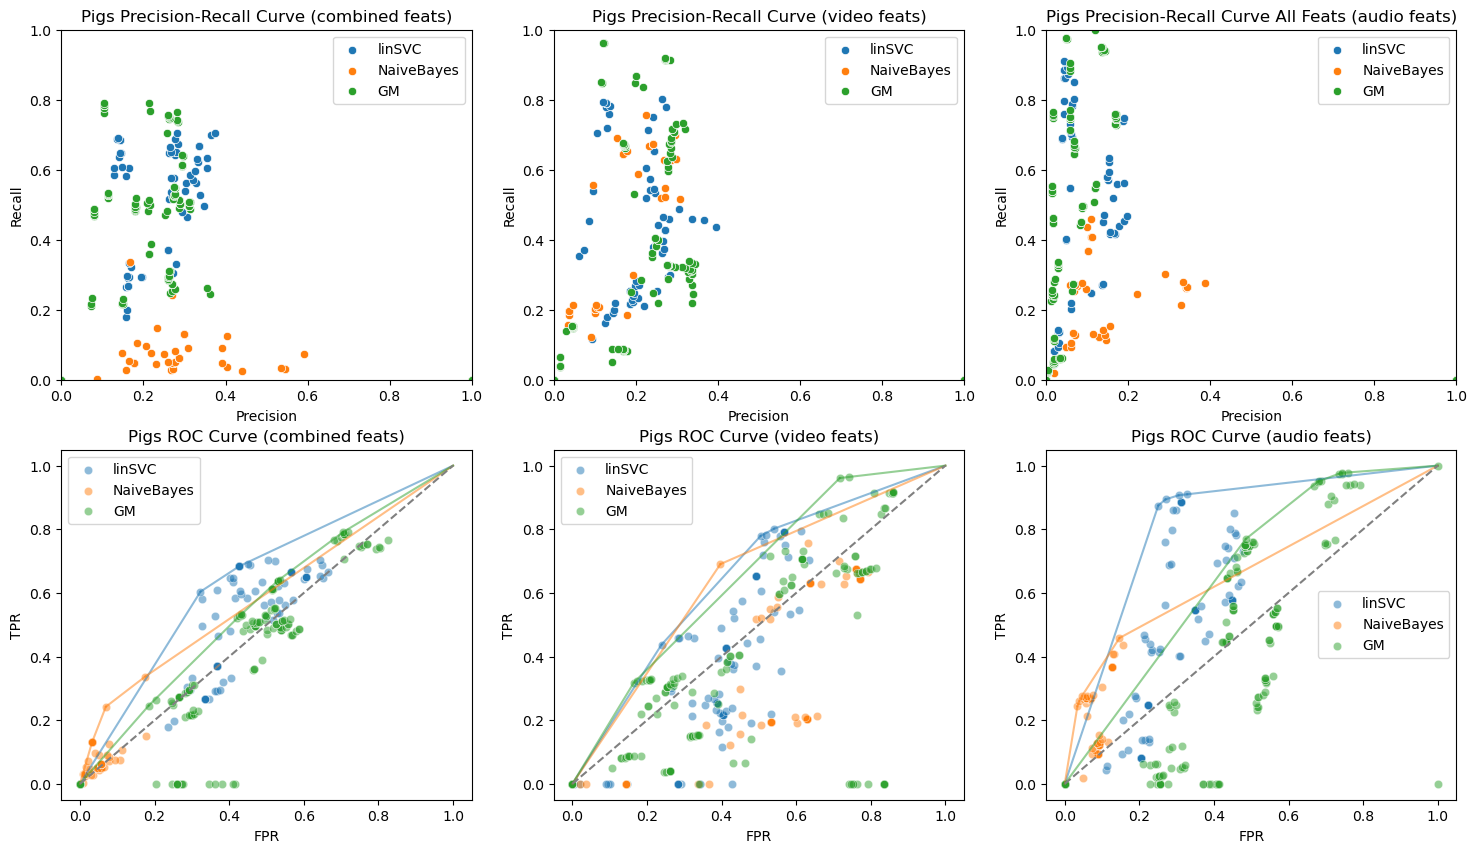

In [72]:
_, axes = plt.subplots(2, 3, figsize=(18, 10))
eval.plot_precision_recall_curve(combined_precision_dict, combined_recall_dict, model_names=combined_clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve (combined feats)', ax=axes[0][0], plot_curve=False, sim_mod='Sim_Mod2')
eval.plot_roc_curve(combined_fpr_dict, combined_tpr_dict, model_names=combined_clf_dict_outer.keys(), title=f'{target_col} ROC Curve (combined feats)', ax=axes[1][0], sim_mod='Sim_Mod2')

eval.plot_precision_recall_curve(video_precision_dict, video_recall_dict, model_names=video_clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve (video feats)', ax=axes[0][1], plot_curve=False, sim_mod='Sim_Mod2')
eval.plot_roc_curve(video_fpr_dict, video_tpr_dict, model_names=video_clf_dict_outer.keys(), title=f'{target_col} ROC Curve (video feats)', ax=axes[1][1], sim_mod='Sim_Mod2')

eval.plot_precision_recall_curve(audio_precision_dict, audio_recall_dict, model_names=audio_clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve All Feats (audio feats)', ax=axes[0][2], plot_curve=False, sim_mod='Sim_Mod2')
eval.plot_roc_curve(audio_fpr_dict, audio_tpr_dict, model_names=audio_clf_dict_outer.keys(), title=f'{target_col} ROC Curve (audio feats)', ax=axes[1][2], sim_mod='Sim_Mod2')

The following curves provide the information about TPR and FPR at different classification thresholds for the best hyperparameter combinations of each model. 

As we can see, the performance of the combined classifier is actually worse than of the video classifier. The reason is probably that in combined classifier, we have to apply PCA due to high number of features, while in the video classifier we use the features directly.

**Combined classifier**

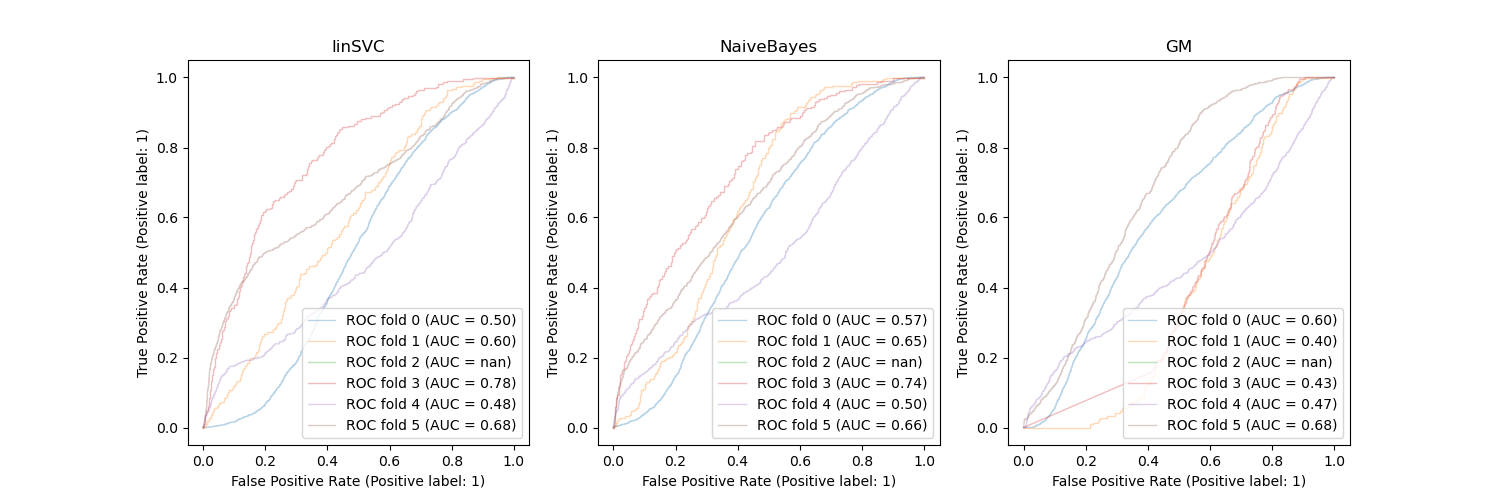

In [75]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_combined_precision_recall.png"
display(Image(filename=filename))

**Video classifier**

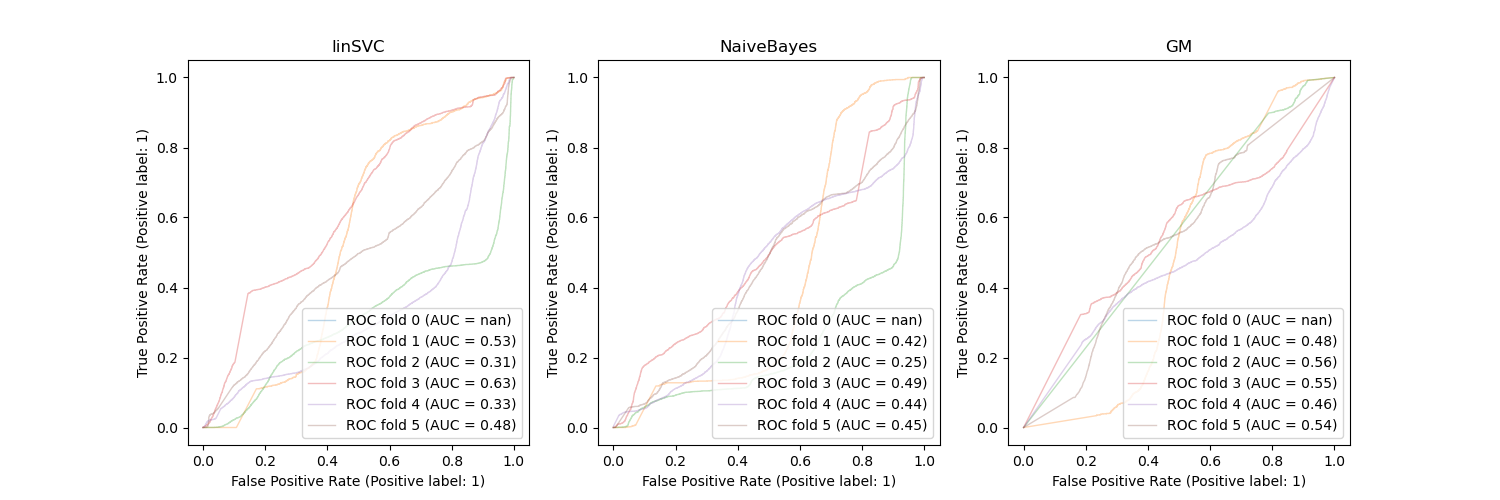

In [61]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_video_precision_recall.png"
display(Image(filename=filename))

**Audio classifier**

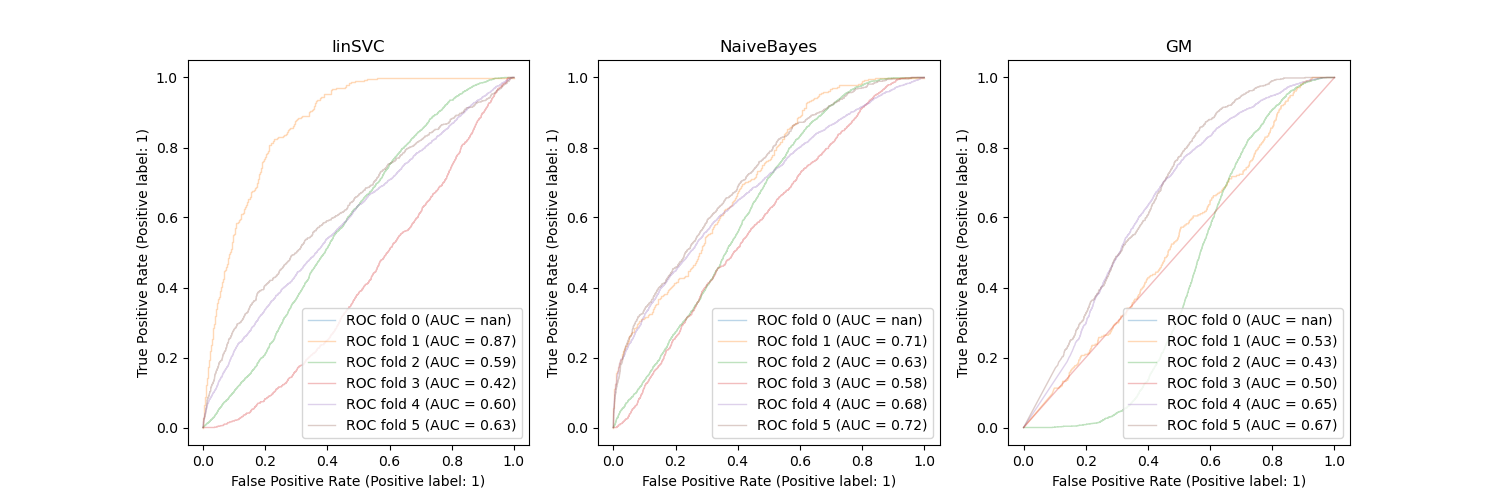

In [63]:
from IPython.display import Image, display
filename = f"../data/eval/DT_Audio_{target_col}_audio_precision_recall.png"
display(Image(filename=filename))

#### 6.2 Cook

In [73]:
target_col = 'Cook'

# combined approach
feat_type = 'combined'
combined_eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
combined_clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
combined_tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))
combined_precision_dict, combined_recall_dict, combined_f1_dict, combined_fpr_dict, combined_tpr_dict = eval.get_eval_info(combined_eval_df, combined_clf_dict_outer)

# video approach
feat_type = 'video'
video_eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
video_clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
video_tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))
video_precision_dict, video_recall_dict, video_f1_dict, video_fpr_dict, video_tpr_dict = eval.get_eval_info(video_eval_df, video_clf_dict_outer)

# audio approach
feat_type = 'audio'
audio_eval_df = pd.read_csv(f"../data/eval/DT_Audio_{target_col}_{feat_type}_eval_df.csv")
audio_clf_dict_outer = pickle.load(open(f"../data/models/DT_Audio_{target_col}_{feat_type}_clf_info.pkl", "rb"))
audio_tprs_dict = pickle.load(open(f"../data/models/DT_Audio_{target_col}_{feat_type}_tpr_info.pkl", "rb"))
audio_precision_dict, audio_recall_dict, audio_f1_dict, audio_fpr_dict, audio_tpr_dict = eval.get_eval_info(audio_eval_df, audio_clf_dict_outer)

The results for Swedish chef are even worse than for the Pigs. But we can see that NaiveBayes still persists in its conviction of at least not being wrong (while also not being right).

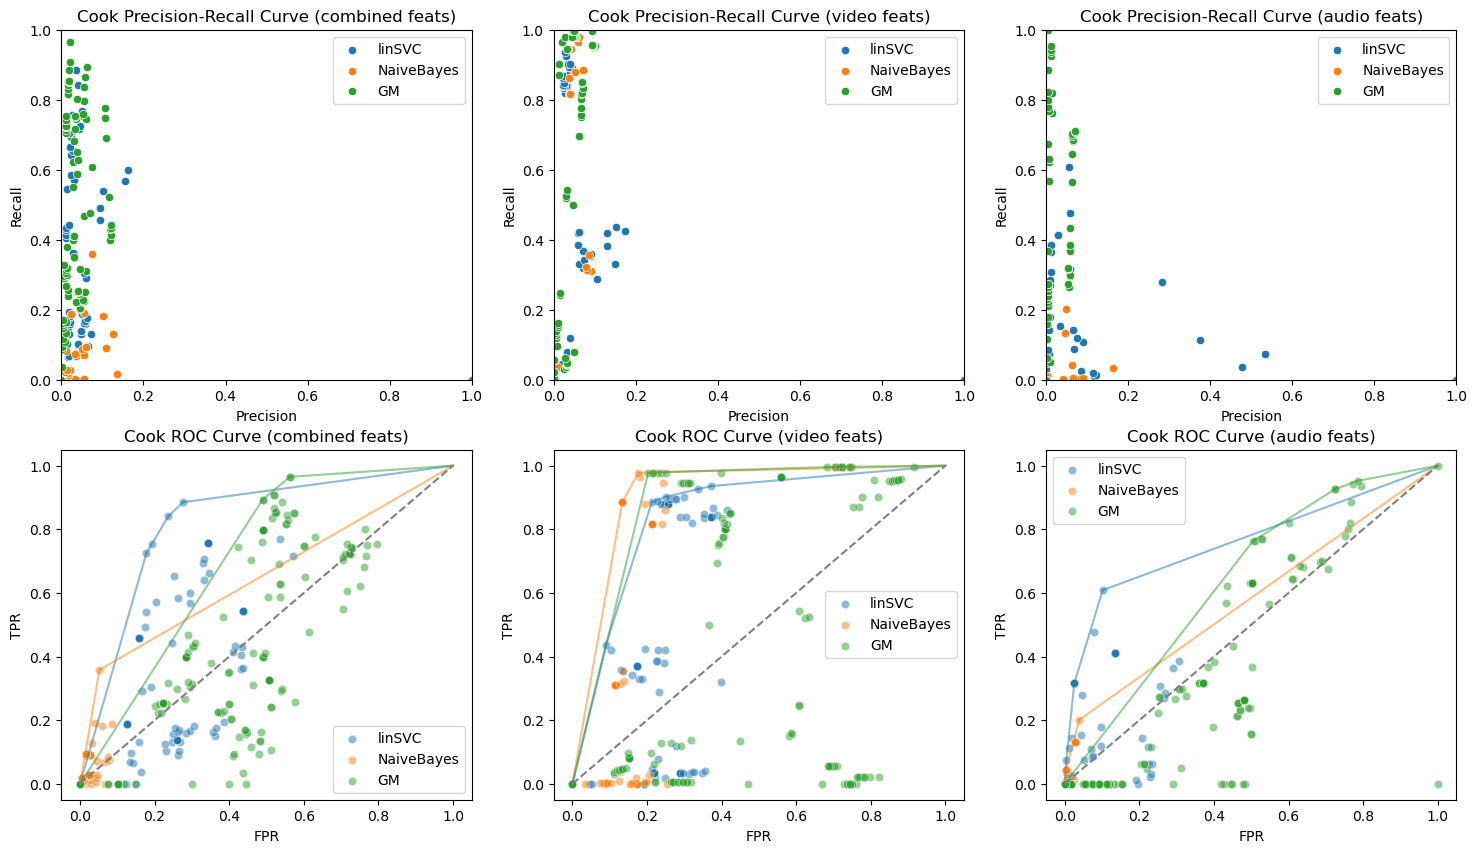

In [74]:
_, axes = plt.subplots(2, 3, figsize=(18, 10))
eval.plot_precision_recall_curve(combined_precision_dict, combined_recall_dict, model_names=combined_clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve (combined feats)', ax=axes[0][0], plot_curve=False, sim_mod='Sim_Mod2')
eval.plot_roc_curve(combined_fpr_dict, combined_tpr_dict, model_names=combined_clf_dict_outer.keys(), title=f'{target_col} ROC Curve (combined feats)', ax=axes[1][0], sim_mod='Sim_Mod2')

eval.plot_precision_recall_curve(video_precision_dict, video_recall_dict, model_names=video_clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve (video feats)', ax=axes[0][1], plot_curve=False, sim_mod='Sim_Mod2')
eval.plot_roc_curve(video_fpr_dict, video_tpr_dict, model_names=video_clf_dict_outer.keys(), title=f'{target_col} ROC Curve (video feats)', ax=axes[1][1], sim_mod='Sim_Mod2')

eval.plot_precision_recall_curve(audio_precision_dict, audio_recall_dict, model_names=audio_clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve (audio feats)', ax=axes[0][2], plot_curve=False, sim_mod='Sim_Mod2')
eval.plot_roc_curve(audio_fpr_dict, audio_tpr_dict, model_names=audio_clf_dict_outer.keys(), title=f'{target_col} ROC Curve (audio feats)', ax=axes[1][2], sim_mod='Sim_Mod2')

Here the situation is comparable to the classification of Pigs: the performance of the combined classifier is actually worse than of the video classifier, probably due to the PCA dimensionality reduction.

**Combined classifier**

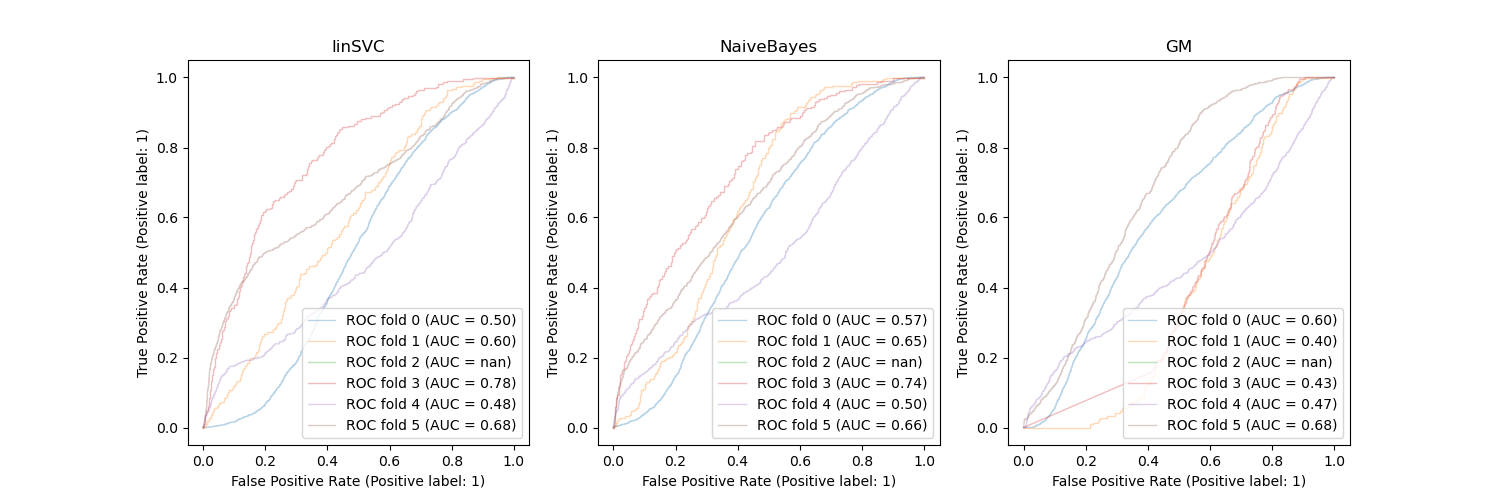

In [76]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_combined_precision_recall.png"
display(Image(filename=filename))

**Video classifier**

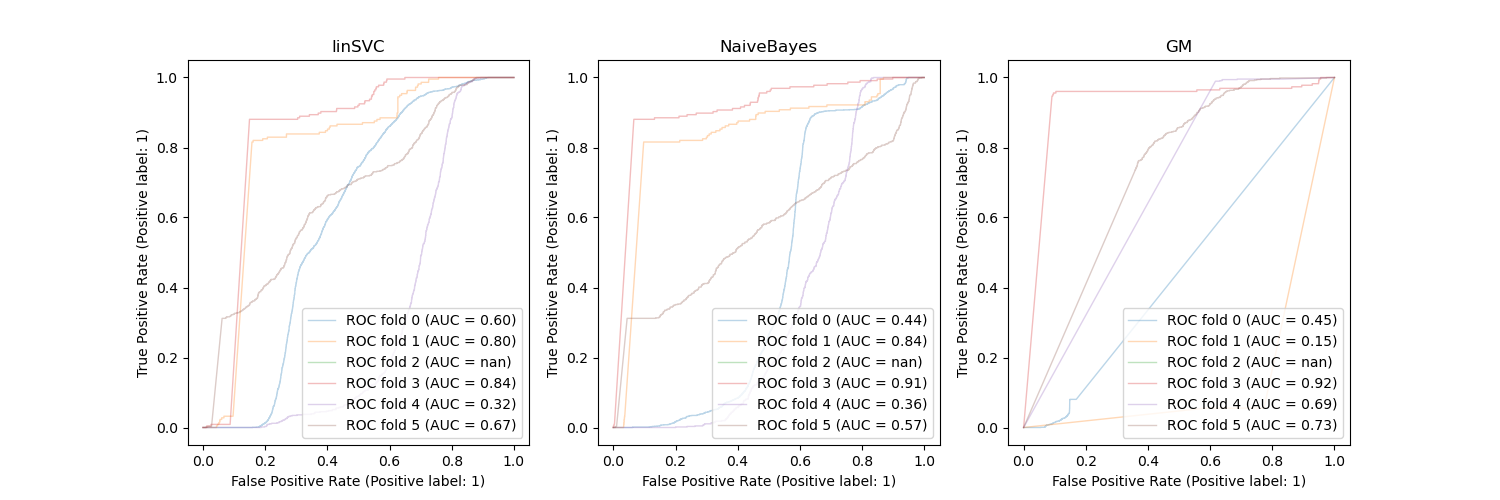

In [77]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_video_precision_recall.png"
display(Image(filename=filename))

**Audio classifier**

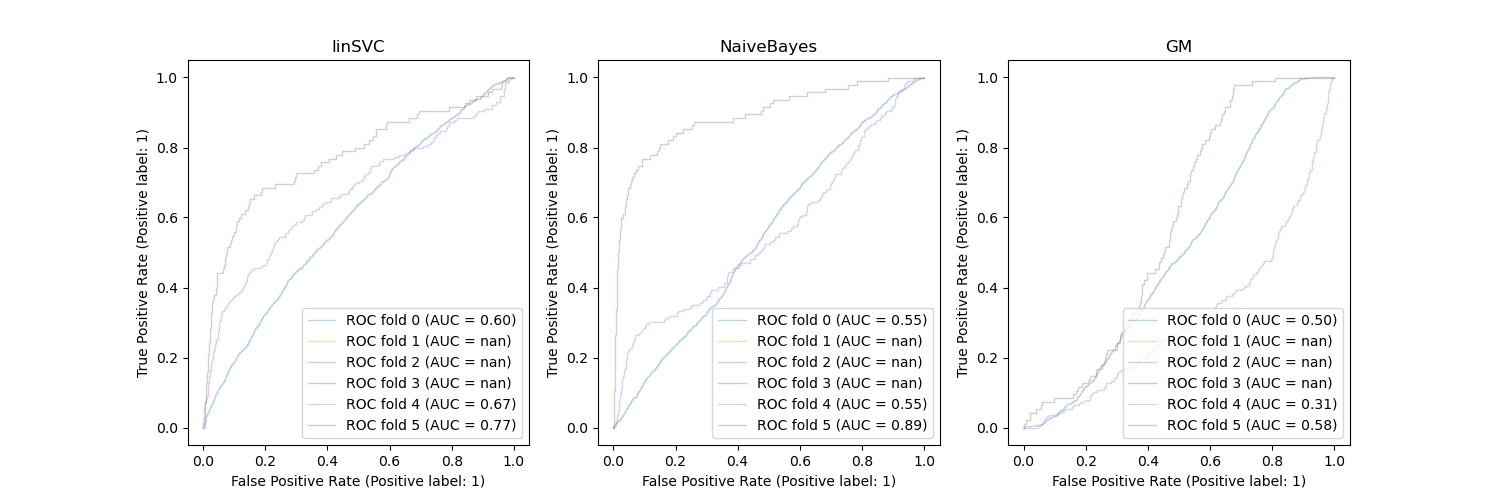

In [78]:
from IPython.display import Image, display
filename = f"../data/eval/DT_Audio_{target_col}_audio_precision_recall.png"
display(Image(filename=filename))

## 7. Conclusion
The classification of Pigs and Swedish chef was very challenging. The first reason is that the dataset is heavily imbalanced, there is a very little number of positive samples in comparison to the negative samples. Especially in case with Swedish chef: he only has 2 scenes, and if one wants to avoid data leakage, one cannot split these scenes into multiple parts, since frames look very similar to each other and we would basically test on the same data we've used for training. This means that we can only train classifier on one scene, which is not enough to create a good classifier.

For video features, the challenge was that the approaches from SimMod2 were not really applicable to this classification problem, since they often required large amount of positive samples or were aimed at static non-changing objects, while in the videos the characters move a lot.

For audio features, another reason why this assignment was challenging is that it was hard to find the ready-made implementations which would be easy to run of the features introduces in SimMod 2 (e.g., i-vectors). Hence we were limited in our choice of features for classification.
